In [0]:
!ls

In [1]:
from __future__ import absolute_import, division, print_function

In [3]:
!pip install gensim

    100% |████████████████████████████████| 22.6MB 1.8MB/s 
    100% |████████████████████████████████| 1.4MB 11.9MB/s 
    100% |████████████████████████████████| 133kB 18.8MB/s 
    100% |████████████████████████████████| 61kB 16.3MB/s 
    100% |████████████████████████████████| 4.4MB 7.4MB/s 
    100% |████████████████████████████████| 552kB 19.6MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /content/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [40]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [41]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [42]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [43]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

In [44]:
chats = sorted(glob.glob("drive/app/Misc/whatsapp/sapp2vec/clean_text.txt"))

In [45]:
print("Found chat:")
chats

Found chat:


['drive/app/Misc/whatsapp/sapp2vec/clean_text.txt']

In [46]:
corpus_raw = u""
for chat in chats:
    print("Reading '{0}'...".format(chat))
    with codecs.open(chat, "r", "utf-8") as chat_file:
        corpus_raw += chat_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'drive/app/Misc/whatsapp/sapp2vec/clean_text.txt'...
Corpus is now 1811190 characters long



**Split the corpus into sentences**

In [47]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [48]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [49]:
#convert into a list of words
#remove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [50]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        raw_sentence = raw_sentence.lower()
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
token_count = sum([len(sentence) for sentence in sentences])
print("The chat corpus contains {0:,} tokens".format(token_count))

The chat corpus contains 1,395,270 tokens


## Train Word2Vec

In [52]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 500
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
#num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [53]:
sapp2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    #workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [54]:
sapp2vec.build_vocab(sentences)

In [55]:
print("Word2Vec vocabulary length:", len(sapp2vec.wv.vocab))

Word2Vec vocabulary length: 8543


In [56]:
sapp2vec.train(sentences,total_examples=sapp2vec.corpus_count,epochs=10)

(100000, 3509730)

In [57]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [58]:
sapp2vec.save(os.path.join("drive/app/Misc/whatsapp/sapp2vec", "sapp2vec.w2v"))

In [59]:
sapp2vec.wv.save_word2vec_format('drive/app/Misc/whatsapp/sapp2vec/sapp2vec.txt', binary=False)

In [60]:
sapp2vec = w2v.Word2Vec.load(os.path.join("drive/app/Misc/whatsapp/sapp2vec", "sapp2vec.w2v"))

### Compress the word vectors into 2D space and plot them

In [61]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [62]:
all_word_vectors_matrix = sapp2vec.wv.syn0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [63]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [64]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[sapp2vec.wv.vocab[word].index])
            for word in sapp2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [65]:
points[points['word']=='scooby']

,word,x,y
665,scooby,-20.275618,-60.507015


In [71]:
points.to_csv("drive/app/Misc/whatsapp/sapp2vec/sapp2vec.csv",index = False)

In [66]:
sns.set_context("poster")

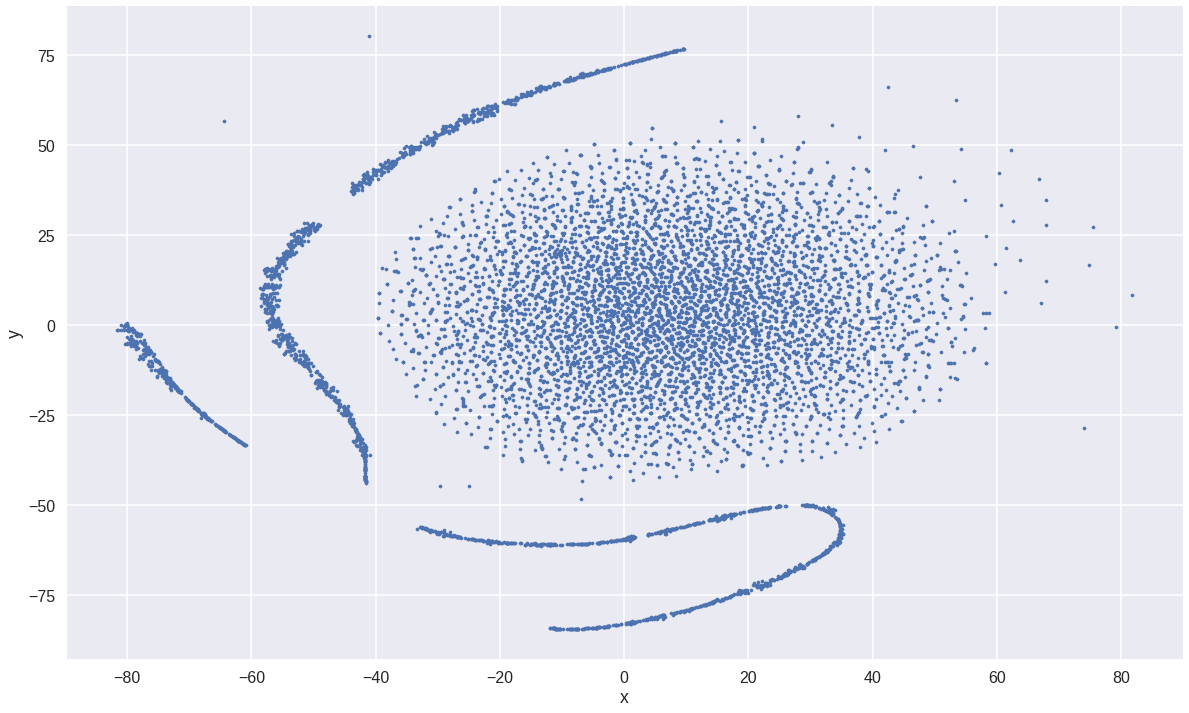

In [70]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [68]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

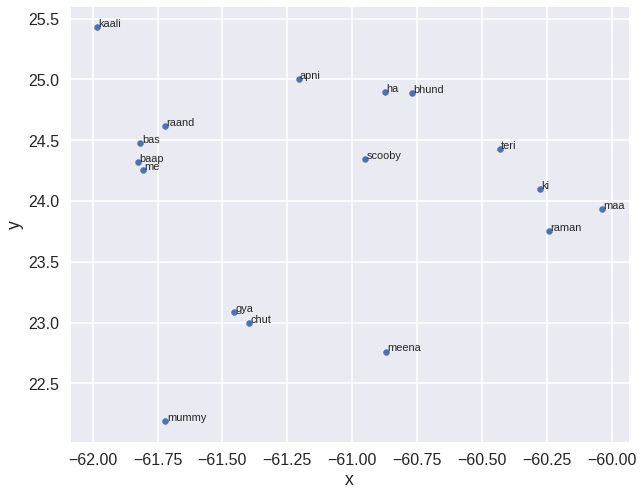

In [43]:
plot_region(x_bounds=(-62,-58 ), y_bounds=(22, 26))

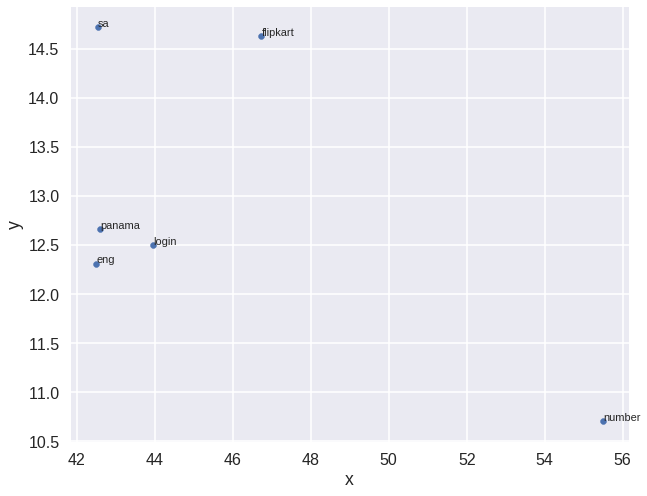

In [50]:
plot_region(x_bounds=(42, 57), y_bounds=(10, 15))

### Explore semantic similarities between words

**Words closest to the given word**

In [0]:
sapp2vec.most_similar("madhar")

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('rajit', 0.8477747440338135),
 ('agya', 0.7562962174415588),
 ('moon', 0.7449634075164795),
 ('khali', 0.7392154932022095),
 ('mereko', 0.7247727513313293),
 ('golu', 0.7215362191200256),
 ('lauda', 0.7185718417167664),
 ('bhadve', 0.7139200568199158),
 ('madarchod', 0.711746096611023),
 ('heheh', 0.711087167263031)]

**Linear relationships between word pairs**

In [0]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = sapp2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [0]:
nearest_similarity_cosmul("madhar", "rajit", "meena")

madhar is related to rajit, as boy is related to meena


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).


'boy'